<a href="https://colab.research.google.com/github/ChoeTaeBin/deep_learning_study/blob/master/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

batch_size : 한번 파라미터를 갱신할때 몇개의 샘플을 이용할 지   
온라인 학습은 batch_size == 1, 배치 학습은 batch_size == 전체 샘플 수 인 미니 배치 학습으로 볼 수 있다.

(batch_size, (한 샘플 차원))이 모델에 들어간다. 즉, 맨 왼쪽에 한 차원이 더해지면 된다.  
  

1epoch : 훈련샘플을 1회 모두 써서 훈련하는 것  

데이터 가져오기

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

img_size = 28 #28*28임

mnist_train = MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

print(f"훈련 데이터의 수:{len(mnist_train)}, 테스트 데이터의 수:{len(mnist_test)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4586711.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 65390.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1088400.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4364382.31it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

훈련 데이터의 수:60000, 테스트 데이터의 수:10000


DataLoader 설정

In [31]:
from torch.utils.data import DataLoader


#batch_size = 1 #online
batch_size = 256 #mini batch

train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle = False)

# #batch
# train_loader = DataLoader(mnist_train, batch_size = len(mnist_train), shuffle = True)
# test_loader = DataLoader(mnist_test, batch_size = len(mnist_test), shuffle = False)

모델 구축

In [32]:
import torch.nn as nn

class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(img_size*img_size, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)
    self.relu = nn.ReLU() #하나만 있으면 된다.(재활용 해도 됨)

  def forward(self, x):
    x = x.view(-1, img_size * img_size) #(배치크기 ,픽셀 수) 모양으로 만듦
    x = self.relu(self.fc1(x))
    x= self.relu(self.fc2(x))
    x = self.fc3(x) #선형 계산 결과를 그대로 내보냄
    return x

In [33]:
net = Net()
net.cuda() #모델 파라미터를 gpu로
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)


optimizer, loss function 생성

In [34]:
from torch import optim

loss_fnc = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01)

학습

In [35]:
num_epochs = 10
record_loss_train = []
record_loss_test = []

for i in range(num_epochs):
  net.train() #훈련 모드로
  loss_train = 0 #현재 에포크의 손실 합

  for j, (x, t) in enumerate(train_loader):
    optimizer.zero_grad() #local gradient 초기화
    x,t = x.cuda(), t.cuda() #각 학습 데이터들을 gpu로
    y = net(x)
    loss = loss_fnc(y, t)
    loss.backward()
    optimizer.step()
    loss_train += loss.item()

  loss_train /= j+1 #평균 손실구함
  record_loss_train.append(loss_train)

  net.eval() #평가 모드로
  loss_test = 0

  for j, (x,t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)
    loss = loss_fnc(y, t)
    loss_test += loss.item()

  loss_test /= j+1
  record_loss_test.append(loss_test)

  #중간 보고

  if i%(num_epochs/10) == 0:
    print(f"Epoch:{i}, Loss_Train:{loss_train}, Loss_test:{loss_test}")

Epoch:0, Loss_Train:2.213699056747112, Loss_test:2.079523652791977
Epoch:1, Loss_Train:1.8018391659919253, Loss_test:1.4068626850843429
Epoch:2, Loss_Train:1.0950396025434452, Loss_test:0.8202848918735981
Epoch:3, Loss_Train:0.7174965891432254, Loss_test:0.5965553671121597
Epoch:4, Loss_Train:0.5626373288479257, Loss_test:0.4925804764032364
Epoch:5, Loss_Train:0.48245599827867874, Loss_test:0.4339103167876601
Epoch:6, Loss_Train:0.435105732527185, Loss_test:0.3959531167522073
Epoch:7, Loss_Train:0.4036256229623835, Loss_test:0.3701112765818834
Epoch:8, Loss_Train:0.3798787590037001, Loss_test:0.3503937343135476
Epoch:9, Loss_Train:0.36227657141837666, Loss_test:0.3362560668960214


오차 추이

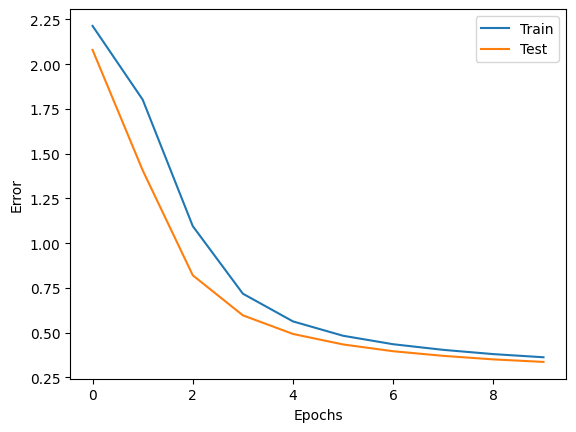

In [36]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label = "Train")
plt.plot(range(len(record_loss_test)),record_loss_test, label = "Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

accuracy계산

In [37]:
correct = 0
total = 0
net.eval() #평가모드

for i, (x,t) in enumerate(test_loader):
  x, t = x.cuda(), t.cuda()
  y = net(x)
  correct += (y.argmax(axis = 1) == t).sum().item()
  total += len(x)

print(f"accuracy:{(correct/total)*100}%")

accuracy:90.42999999999999%
